In [1]:
#Import Library
from torchvision import datasets
import torchvision.transforms as transforms
import collections
from torchvision import utils
from torch.utils.data import DataLoader
from torchsummary import summary
from torch import nn
from torch import optim
import torch
import torchvision
import matplotlib.pyplot as plt
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Loader

In [3]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

image_directory = r'dataset-original\dataset-original'
dataset = ImageFolder(image_directory, transform=ToTensor())

In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: dataset-original\dataset-original
    StandardTransform
Transform: ToTensor()

In [5]:
from torch.utils.data import DataLoader, random_split, Dataset

# Custom Dataset to apply transformations after loading
class TransformDataset(Dataset):
    def __init__(self, dataset, classes, transform=None):
        self.dataset = dataset
        self.classes = classes
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the dataset from the directory
image_directory = r'dataset-original\dataset-original'
dataset = ImageFolder(image_directory, transform=ToTensor())

# Print the total number of images in the dataset
print(f'Total number of images in the dataset: {len(dataset)}')

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print sizes of each split
print(f'Train dataset size after split: {len(train_dataset)}')
print(f'Validation dataset size after split: {len(val_dataset)}')
print(f'Test dataset size after split: {len(test_dataset)}')


Total number of images in the dataset: 2527
Train dataset size after split: 2021
Validation dataset size after split: 252
Test dataset size after split: 254


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #resize images
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))        
])

In [7]:
train_dataset = TransformDataset(train_dataset, dataset.classes, transform=transform)
val_dataset = TransformDataset(val_dataset, dataset.classes, transform=transform)
test_dataset = TransformDataset(test_dataset, dataset.classes, transform=transform)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Exploration Image Analysis

In [8]:
# Verify the splits
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')

Training set size: 2021
Validation set size: 252
Test set size: 254


In [9]:
# Check if the dataset has the 'classes' attribute
if hasattr(train_loader.dataset, 'classes'):
    # Print the class labels
    print(f'Class labels: {train_loader.dataset.classes}')
else:
    print("The dataset does not have a 'classes' attribute")

Class labels: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [10]:
# from collections import Counter
# # Function to count labels in a DataLoader
# def count_labels(loader):
#     counter = Counter()
#     for _, labels in loader:
#         counter.update(labels.tolist())
#     return counter

# # Count labels in each DataLoader
# train_labels_count = count_labels(train_loader)
# val_labels_count = count_labels(val_loader)
# test_labels_count = count_labels(test_loader)

# # Print label counts
# print(f'Training set label counts: {train_labels_count}')
# print(f'Validation set label counts: {val_labels_count}')
# print(f'Test set label counts: {test_labels_count}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558843..1.8200003].


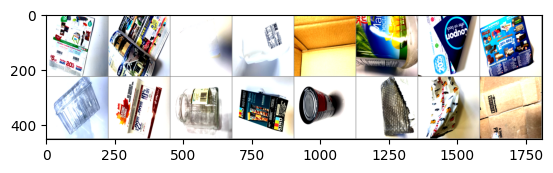

paper paper paper plastic cardboard plastic paper paper plastic paper glass paper metal plastic trash cardboard


In [11]:
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels using the classes attribute from the original dataset
print(' '.join(f'{train_dataset.classes[labels[j]]:5s}' for j in range(len(labels))))

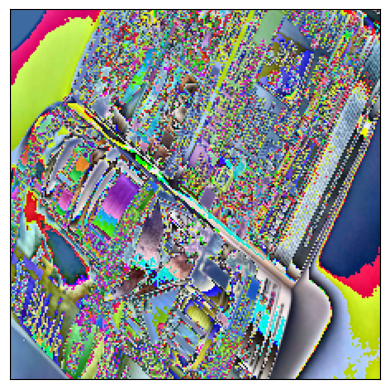

In [12]:
import torchvision.transforms.functional as F
import numpy as np
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Extract the image tensor from the dataset
image, label = train_loader.dataset[1]
show(image)

## Modelling

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the convolution layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=0) # Output: (224 - 3 + 2*0)/1 + 1 = 222
        self.pool = nn.MaxPool2d(2, 2)              # Output: 222 / 2 = 111
        self.conv2 = nn.Conv2d(16, 32, 3, padding=0) # Output: (111 - 3 + 2*0)/1 + 1 = 109
        self.conv3 = nn.Conv2d(32, 32, 3, padding=0) # Output: (109 - 3 + 2*0)/1 + 1 = 107
        self.conv4 = nn.Conv2d(32, 64, 3, padding=0) # Output: (107 - 3 + 2*0)/1 + 1 = 105
        self.pool2 = nn.MaxPool2d(2, 2)             # Output: 105 / 2 = 52 (rounded down)

        # Calculate the size of the flattened features after last pooling
        feature_size = 64 * 52 * 52  # flatten for fully connected

        # Define the fully connected layers
        self.fc1 = nn.Linear(feature_size, 100)
        self.dropout1 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(100, 80)
        self.fc3 = nn.Linear(80, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except the batch
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout1(x)
        x = self.fc3(x)
        return x
    
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(net.parameters(), lr=0.0001)

In [14]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    return correct / total

In [15]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(15):  # loop over the dataset multiple times
    net.train()
    running_loss, running_acc = 0.0, 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += calculate_accuracy(outputs, labels)
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(running_acc / len(train_loader))

    net.eval()
    val_loss, val_acc = 0.0, 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += calculate_accuracy(outputs, labels)
            _, preds = torch.max(outputs, 1)  
            all_preds.extend(preds.cpu().numpy())  
            all_labels.extend(labels.cpu().numpy())  
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc / len(val_loader))
    

    print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.2f}, Train Acc: {train_accs[-1]:.2f}, Val Loss: {val_losses[-1]:.2f}, Val Acc: {val_accs[-1]:.2f}')

In [16]:
# def train_one_epoch(epoch, model, criterion, optimizer, data_loader, device):
#     model.train()
#     running_loss, running_acc = 0.0, 0.0
#     for inputs, labels in data_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#         running_acc += calculate_accuracy(outputs, labels)
#     return running_loss / len(data_loader), running_acc / len(data_loader)

# def validate(model, criterion, data_loader, device):
#     model.eval()
#     val_loss, val_acc = 0.0, 0.0
#     with torch.no_grad():
#         for inputs, labels in data_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             val_acc += calculate_accuracy(outputs, labels)
#     return val_loss / len(data_loader), val_acc / len(data_loader)

# with torch.profiler.profile(
#     activities=[
#         torch.profiler.ProfilerActivity.CPU,
#         torch.profiler.ProfilerActivity.CUDA,
#     ],  
#     schedule=torch.profiler.schedule(
#         wait=1,
#         warmup=1,
#         active=3,
#         repeat=2
#     ),
#     on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
# ) as p:
#     for epoch in range(10):
#         train_loss, train_acc = train_one_epoch(epoch, net, criterion, optimizer, train_loader, device)
#         val_loss, val_acc = validate(net, criterion, val_loader, device)
#         p.step()  # Step the profiler
#         print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.2f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.2f}, Val Acc: {val_acc:.2f}')

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
# Plot training dan validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label = 'training_loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()